
---

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# **CGAN By Bhupinder Singh (500218900)**


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

---

## here are the example of images generated by the following CGAN

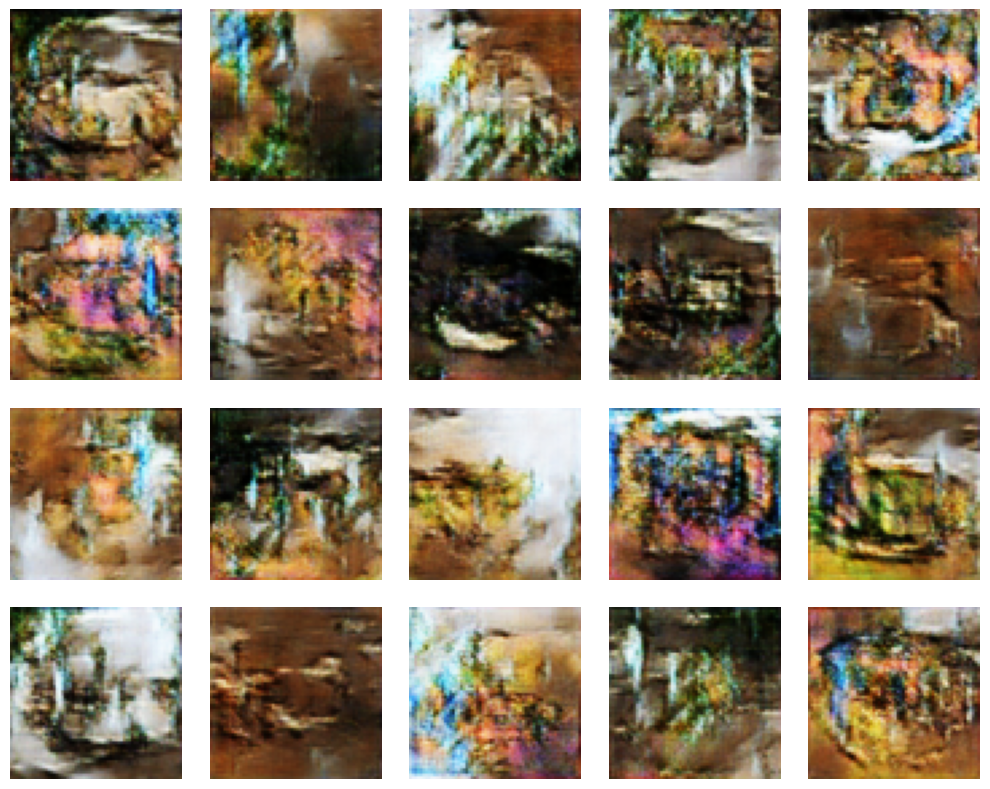

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
image_files = [f"generated_image_{i}.png" for i in range(20)]
rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
axes = axes.flatten()
for ax, img_file in zip(axes, image_files):
    if os.path.exists(img_file):
        img = mpimg.imread(img_file)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.set_visible(False) 
plt.tight_layout(w_pad=2, h_pad=2) 
plt.show()

## Installing python libraries

In [ ]:
import os
import json
import random
import torch
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from PIL import Image
import matplotlib.pyplot as plt

## Loading Json file and Images

In [ ]:
class YelpDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None, num_samples=10000):
        self.img_dir = img_dir
        self.transform = transform
        temp_data = []
        with open(json_path, 'r') as f:
            for line in f:
                try:
                    item = json.loads(line.strip())
                    if item['label'] in ['food', 'drink', 'inside', 'outside']:
                        img_path = os.path.join(self.img_dir, item['photo_id'] + '.jpg')
                        if os.path.exists(img_path):
                            try:
                                
                                with Image.open(img_path) as img:
                                    img.verify()
                                temp_data.append(item)
                            except Exception as e:
                                print(f"Skipping corrupted image {img_path}: {str(e)}")
                                continue
                except json.JSONDecodeError:
                    continue
                except Exception as e:
                    print(f"Error processing entry: {str(e)}")
                    continue
        
        self.label_map = {
            'food': 0,
            'drink': 1,
            'inside': 2,
            'outside': 3
        }
        
        if len(temp_data) > num_samples:
            self.data = random.sample(temp_data, num_samples)
        else:
            self.data = temp_data
            print(f"Warning: Only found {len(self.data)} valid images")
        print(f"Dataset initialized with {len(self.data)} images")
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.img_dir, self.data[idx]['photo_id'] + '.jpg')
                image = Image.open(img_path).convert('RGB')
                label = self.label_map[self.data[idx]['label']]
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                print(f"Error loading image at index {idx}, trying next index")
                idx = (idx + 1) % len(self.data)


## Generator code

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = 64 // 4  
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.Linear(256 * 8 * 8 + num_classes, 1),
            nn.Sigmoid()
        )
    def forward(self, img, labels):
        feat = self.model(img)
        feat = feat.view(feat.shape[0], -1)
        label_embedding = self.label_embedding(labels)
        feat = torch.cat((feat, label_embedding), -1)
        validity = self.output(feat)
        return validity

## Training cGAN

In [ ]:
def train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device):
    adversarial_loss = torch.nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(dataloader):
            batch_size = real_imgs.shape[0]
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, 4, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            g_loss.backward()
            optimizer_G.step()
            optimizer_D.zero_grad()
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
                )

## Evaluation Matrices 

In [ ]:
def calculate_inception_score(generator, num_samples=1000, batch_size=32, splits=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inception_model = inception_v3(weights='DEFAULT', transform_input=False)
    inception_model.aux_logits = False
    inception_model.to(device)
    inception_model.eval()
    generator.eval()
    all_preds = []
    
    try:
        with torch.no_grad():
            for _ in tqdm(range(num_samples // batch_size), desc="Generating samples"):
                z = torch.randn(batch_size, generator.latent_dim).to(device)
                labels = torch.randint(0, 4, (batch_size,)).to(device)
                fake_images = generator(z, labels)
                fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
                if device.type == 'cuda' and torch.cuda.memory_allocated() > torch.cuda.get_device_properties(0).total_memory * 0.8:
                    inception_model.to('cpu')
                    fake_images = fake_images.cpu()
                    device = torch.device('cpu')
                pred = inception_model(fake_images)
                pred = F.softmax(pred, dim=1)
                all_preds.append(pred.cpu().numpy())
                
    except RuntimeError as e:
        print(f"Runtime error occurred: {e}")
        print("Switching to CPU...")
        device = torch.device('cpu')
        inception_model.to(device)
        generator.to(device)
        return calculate_inception_score(generator, num_samples, batch_size, splits, device)
    all_preds = np.concatenate(all_preds, axis=0)
    scores = []
    for i in range(splits):
        part = all_preds[(i * num_samples // splits):((i + 1) * num_samples // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

def calculate_fid(real_images, generated_images, batch_size=32, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inception_model = inception_v3(weights='DEFAULT', transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model.aux_logits = False
    inception_model.to(device)
    inception_model.eval()
    def get_activations(images):
        activations = []
        for img_batch in images.split(batch_size):
            if img_batch.shape[-1] != 299:
                img_batch = F.interpolate(img_batch, size=(299, 299), mode='bilinear', align_corners=False)
            img_batch = img_batch.to(device)
            with torch.no_grad():
                act = inception_model(img_batch)
            activations.append(act.cpu())
        return torch.cat(activations, 0)
    
    real_activations = get_activations(real_images)
    fake_activations = get_activations(generated_images)
    mu1 = torch.mean(real_activations, dim=0)
    sigma1 = torch.cov(real_activations.T)
    mu2 = torch.mean(fake_activations, dim=0)
    sigma2 = torch.cov(fake_activations.T)
    diff = mu1 - mu2
    covmean = torch.sqrt(sigma1.mm(sigma2))
    
    if torch.any(torch.isnan(covmean)):
        offset = torch.eye(sigma1.size(0)) * 1e-6
        covmean = torch.sqrt((sigma1 + offset).mm(sigma2 + offset))
    fid = diff.dot(diff) + torch.trace(sigma1) + torch.trace(sigma2) - 2 * torch.trace(covmean)
    return fid.item()

## Lets genrate and check our images

In [ ]:
def generate_sample_images(generator, latent_dim, device=None, num_samples=5, save_images=True):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.randint(0, 4, (num_samples,)).to(device)
        generated_images = generator(z, labels)
        generated_images = generated_images.cpu()
        generated_images = (generated_images + 1) / 2 
        if save_images:
            for i in range(num_samples):
                img = transforms.ToPILImage()(generated_images[i]) 
                img.save(f"generated_image_{i}.png")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].permute(1, 2, 0))
            ax.axis('off')
        plt.show()
        return generated_images


## This function is for training and calculation loss for the CGAN

In [ ]:

def train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device):
    adversarial_loss = torch.nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(dataloader):
            batch_size = real_imgs.shape[0]
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            optimizer_G.zero_grad()
            
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, 4, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            g_loss.backward()
            optimizer_G.step()
            optimizer_D.zero_grad()
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            optimizer_D.step()
            
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
                )


## Main function

Skipping corrupted image D:\LCIT\Sem - 3\2007-DL\week-9\assignment-3\photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\ydm3g1wUWSxJnMPgHk2JhQ.jpg'
Skipping corrupted image D:\LCIT\Sem - 3\2007-DL\week-9\assignment-3\photos\JGpfPj8VEvnq1B-Xqr3w-A.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\JGpfPj8VEvnq1B-Xqr3w-A.jpg'
Skipping corrupted image D:\LCIT\Sem - 3\2007-DL\week-9\assignment-3\photos\bf3ymV0YgP7B6rEoriaU2w.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\bf3ymV0YgP7B6rEoriaU2w.jpg'
Skipping corrupted image D:\LCIT\Sem - 3\2007-DL\week-9\assignment-3\photos\juDNZOOnkgG3QINFrulsAg.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\juDNZOOnkgG3QINFrulsAg.jpg'
Skipping corrupted image D:\LCIT\Sem - 3\2007-DL\week-9\assignment-3\photos\9X4YPM8nYFjf7hY8xUdc6Q.jpg: cannot identify image fi

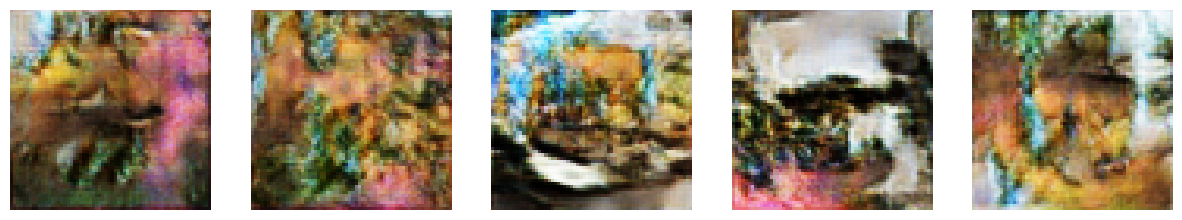

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 40.8MB/s] 
Generating samples: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]


Inception Score: 2.3129100799560547 ± 0.11871355772018433


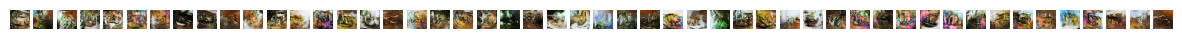

FID Score: nan


In [ ]:
def main():
    latent_dim = 120
    num_classes = 4
    batch_size = 64
    num_epochs = 20
    image_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    dataset = YelpDataset(
        json_path='D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos.json',
        img_dir='D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos',
        transform=transform,
        num_samples= 10000
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    generator = Generator(latent_dim, num_classes).to(device)
    discriminator = Discriminator(num_classes).to(device)
    train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device)
    
    generate_sample_images(generator, latent_dim, device)
    try:
        inception_score, inception_score_std = calculate_inception_score(
            generator, num_samples=1000, batch_size=32, splits=10, device=device
        )
        print(f"Inception Score: {inception_score} ± {inception_score_std}")
    except Exception as e:
        print(f"Error calculating inception score: {e}")
        inception_score = inception_score_std = None
    try:
        fid_score = calculate_fid(
            next(iter(dataloader))[0], 
            generate_sample_images(generator, latent_dim, device, num_samples=50),
            batch_size=32,
            device=device
        )
        print(f"FID Score: {fid_score}")
    except Exception as e:
        print(f"Error calculating FID score: {e}")
        fid_score = None
if __name__ == "__main__":
    main()

## We can see here final images are decent for the amount of training data and time the model was trainined for.
## Genrator is definally picking the pattern here for the food images and genrating some kind of food item in the center of the image .